# LOAD MODULES

In [16]:
import os
import sys
import datetime as dt
import numpy as np
import pandas as pd
from scipy import stats
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import plotly.express as px
import seaborn as sn
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()
import get_audience_compare_raw_data as get_compare_data
#from importlib import reload
#reload(get_compare_data)

## INPUT INTEREST IDS FOR DATA COLLECTION
### Input any number of interest IDs to collect behavioral data for comparison (in list form between brackets).

In [2]:
# THIS CELL IS EDITABLE

interest_ids = [6230,19296,6034,45668,18620]

## COLLECT DATA FOR AUDIENCE COMPARE ANALYSIS

In [3]:
## RUN THIS CELL TO LOAD DATA

### This will take a minute or so
subject_interest_descr = sorted(list(get_compare_data.get_interest_descr_df(interest_ids)['interest']))
subject_interest_descr_reverse = sorted(subject_interest_descr,reverse=True)
print('Pulling audience compare data for {0}'.format(str(subject_interest_descr)[1:-1]))
audience_compare_data = get_compare_data.get_audience_compare_data(interest_ids)
audience_compare_data_category = get_compare_data.get_audience_compare_data_by_category(audience_compare_data)
attribute_categories_list = sorted(list(audience_compare_data_category['attribute_interest_type_category'].unique()))
attribute_categories_list.insert(0,'All')

Pulling audience compare data for 'BBQ Enthusiasts', 'Backyard Farmers', 'Mexican Food Enthusiasts', 'Pizza Lovers', 'Vegans'


## CALCULATE AUDIENCE SIMILARITY SCORES
### View the audience correlation matrix, calculated based on similarity of interest rankings
### Red = Similar / Blue = Opposite / White = Little in Common

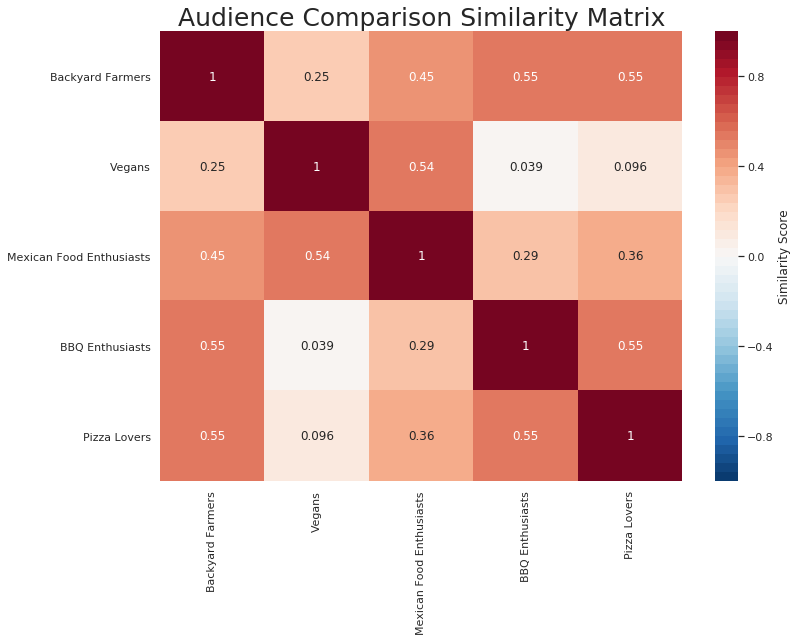

In [15]:
get_compare_data.calculate_similarity_matrix(audience_compare_data)

## CHOOSE TWO AUDIENCES TO COMPARE
### Identify attribute interests and categories with greatest and smallest variances

In [9]:
@interact
def audience_compare_plot(audience_1 = subject_interest_descr,
                          audience_2 = subject_interest_descr_reverse,
                          attribute_type = ['Crafted Audience','Content Cluster','Location Audience','Predictive Location Audience'],
                          metric = ['percentile_rank','index','composition'],
                          view_by = ['Attribute Interest','Attribute Interest Category'],
                          sort_by = ['Ranks High for Both','Ranks Higher for Audience 1','Ranks Higher for Audience 2'],
                          category = attribute_categories_list,
                          results_limit = widgets.IntSlider(min=5, max=100, step=5, value=10),
                         save_as_csv = False):
    
    results_limit = results_limit *2
    if sort_by == 'Ranks High for Both':
        plot_title = 'Interests That Rank High for Both Audiences'
    elif sort_by == 'Ranks Higher for Audience 1':
        plot_title = 'Interests That Rank Higher for {0}'.format(audience_1)
    else:
        plot_title = 'Interests That Rank Higher for {0}'.format(audience_2)
    if view_by == 'Attribute Interest':
        compare_df =  audience_compare_data.loc[(audience_compare_data.subject_interest == audience_1) |
                                               (audience_compare_data.subject_interest == audience_2)]
        compare_df = compare_df.loc[compare_df.attribute_interest_type == attribute_type]
        if category == 'All':
            compare_df = compare_df
        else:
            compare_df = compare_df.loc[compare_df.attribute_interest_type_category == category]
        aud1_df = compare_df.loc[compare_df.subject_interest == audience_1][['attribute_interest',metric]]
        aud1_df.columns = ['attribute_interest','aud1_metric']
        aud2_df = compare_df.loc[compare_df.subject_interest == audience_2][['attribute_interest',metric]]
        aud2_df.columns = ['attribute_interest','aud2_metric']
        delta_df = pd.merge(aud1_df,aud2_df,how='inner',on='attribute_interest')
        delta_df['delta'] = delta_df['aud1_metric'] - delta_df['aud2_metric']
        delta_df['audience_avg'] = (delta_df['aud1_metric'] + delta_df['aud2_metric']) / 2
        delta_df['delta_abs'] = delta_df['delta'].abs()
        plot_df = pd.merge(compare_df,delta_df,how='inner',on='attribute_interest')
        if sort_by == 'Ranks Higher for Audience 1':
            plot_df = plot_df.loc[plot_df.delta>0]
            plot_df = plot_df.sort_values(by='delta',ascending=False)
            plot_df = plot_df[:results_limit]
        elif sort_by == 'Ranks Higher for Audience 2':
            plot_df = plot_df.loc[plot_df.delta<0]
            plot_df = plot_df.sort_values(by='delta')
            plot_df = plot_df[:results_limit]
        else:
            plot_df = plot_df.sort_values(by='delta_abs')
            if metric == 'percentile_rank':
                plot_df = plot_df.loc[(plot_df.aud1_metric >= 0.75) & (plot_df.aud2_metric >= 0.75)]
            plot_df = plot_df[:results_limit]
            plot_df = plot_df.sort_values(by=metric,ascending=False)
    
    else:
        compare_df =  audience_compare_data_category.loc[(audience_compare_data_category.subject_interest == audience_1) |
                                                         (audience_compare_data_category.subject_interest == audience_2)]
        compare_df = compare_df.loc[compare_df.attribute_interest_type == attribute_type]
        if category == 'All':
            compare_df = compare_df
        else:
            compare_df = compare_df.loc[compare_df.attribute_interest_type_category == category]
        aud1_df = compare_df.loc[compare_df.subject_interest == audience_1][['attribute_interest_type_category','{0}_median'.format(metric)]]
        aud1_df.columns = ['attribute_interest_type_category','aud1_metric']
        aud2_df = compare_df.loc[compare_df.subject_interest == audience_2][['attribute_interest_type_category','{0}_median'.format(metric)]]
        aud2_df.columns = ['attribute_interest_type_category','aud2_metric']
        delta_df = pd.merge(aud1_df,aud2_df,how='inner',on='attribute_interest_type_category')
        delta_df['delta'] = delta_df['aud1_metric'] - delta_df['aud2_metric']
        delta_df['audience_avg'] = (delta_df['aud1_metric'] + delta_df['aud2_metric']) / 2
        delta_df['delta_abs'] = delta_df['delta'].abs()
        plot_df = pd.merge(compare_df,delta_df,how='inner',on='attribute_interest_type_category')
        if sort_by == 'Ranks Higher for Audience 1':
            plot_df = plot_df.loc[plot_df.delta>0]
            plot_df = plot_df.sort_values(by='delta',ascending=False)
            plot_df = plot_df[:results_limit]
        elif sort_by == 'Ranks Higher for Audience 2':
            plot_df = plot_df.loc[plot_df.delta<0]
            plot_df = plot_df.sort_values(by='delta')
            plot_df = plot_df[:results_limit]
        else:
            plot_df = plot_df.sort_values(by='delta_abs')
            if metric == 'percentile_rank':
                plot_df = plot_df.loc[(plot_df.aud1_metric >= 0.6) & (plot_df.aud2_metric >= 0.6)]
            plot_df = plot_df[:results_limit]
            plot_df = plot_df.sort_values(by='{}_median'.format(metric),ascending=False)
    
    ### PLOTLY SYNTAX
    if view_by == 'Attribute Interest':
        x_axis_label = 'attribute_interest'
        y_axis_label = metric
    else:
        x_axis_label = 'attribute_interest_type_category'
        y_axis_label = '{0}_median'.format(metric)
    
    fig = px.bar(plot_df, x=plot_df[x_axis_label], 
                 y=plot_df[y_axis_label], 
                 color="subject_interest", 
                 barmode = "group", 
                 title="{0} vs. {1}: {2}".format(audience_1,audience_2,plot_title))
    fig.update_layout(legend_orientation="h")
    fig.update_layout(legend=dict(x=0, y=1.15, font=dict(size=10)))
    fig.update_layout(title=dict(x=0.5,y=0.95,font=dict(size=14)))
    fig.show()
    
    if view_by == 'Attribute Interest':
        table_df = plot_df.pivot(index='attribute_interest',columns='subject_interest',values=metric).reset_index()
        table_df = pd.merge(plot_df[['attribute_interest','delta']],table_df,on='attribute_interest')
        table_df = table_df[['attribute_interest',audience_1,audience_2,'delta']].drop_duplicates()
        table_df = table_df.rename(columns={'delta': '{0}_delta'.format(metric)})
    else:
        table_df = plot_df.pivot(index='attribute_interest_type_category',columns='subject_interest',values='{0}_median'.format(metric)).reset_index()
        table_df = pd.merge(plot_df[['attribute_interest_type_category','delta']],table_df,on='attribute_interest_type_category')
        table_df = table_df[['attribute_interest_type_category',audience_1,audience_2,'delta']].drop_duplicates()
        table_df = table_df.rename(columns={'delta': '{0}_delta'.format(metric)})
    if save_as_csv is True:
        if sort_by == 'Ranks Higher for Audience 1':
            table_df.to_csv('{0}_v_{1}_{2}_{3}_{4}.csv'.format(audience_1.lower().replace(' ','_'),
                                                               audience_2.lower().replace(' ','_'),
                                                               sort_by.lower().replace(' ','_')[:16],
                                                               audience_1.lower().replace(' ','_')),index=False)
        if sort_by == 'Ranks Higher for Audience 2':
            table_df.to_csv('{0}_v_{1}_{2}_{3}.csv'.format(audience_1.lower().replace(' ','_'),
                                                       audience_2.lower().replace(' ','_'),
                                                       sort_by.lower().replace(' ','_')[:16],
                                                          audience_2.lower().replace(' ','_')),index=False)
        else:
            table_df.to_csv('{0}_v_{1}_{2}.csv'.format(audience_1.lower().replace(' ','_'),
                                                       audience_2.lower().replace(' ','_'),
                                                       sort_by.lower().replace(' ','_')),index=False)
    return table_df

interactive(children=(Dropdown(description='audience_1', options=('BBQ Enthusiasts', 'Backyard Farmers', 'Mexi…